## Maximum Billboard Covering Location Problem (MBCLP) solved by Gurobi

In [1]:
from gurobipy import *

In [2]:
def gurobi_solver_MCLP(users, facilities, demand, PN, A):
    # Problem datas
    N = len(users)
    M = len(facilities)

    model = Model('MCLP')
    model.setParam('OutputFlag', False)
    model.setParam('MIPFocus', 2)
    # Add variables
    client_var = {}
    serv_var = {}

    # Add Client Decision Variables and Service Decision Variables
    for j in range(N):
        client_var[j] = model.addVar(vtype="B", name="y(%s)"%j)
    for i in range(M):
        serv_var[i] = model.addVar(vtype="B", name="x(%s)"%i)
    # Update Model Variables
    model.update()
    #     Set Objective Function
    model.setObjective(quicksum(demand[j]*client_var[j] for j in range(N)), GRB.MAXIMIZE)
    #     Add Constraints
    # Add Coverage Constraints
    for j in range(N):
        model.addConstr(quicksum (A[i,j]*serv_var[i] for i in range(M)) - client_var[j] >= 0,
                        'Coverage_Constraint_%d' % j)

    # Add Facility Constraint
    model.addConstr(quicksum(serv_var[i] for i in range(M)) == PN,
                "Facility_Constraint")

    model.optimize()

    # return a stardard result list
    x_result = []
    for i in range(M):
        x_result.append(serv_var[i].X)
    y_result = []
    for j in range(N):
        y_result.append(client_var[j].X)
    obj = model.ObjVal
    return x_result, y_result, obj

## Load the real-world datasets

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### LandScan Population Distribution
LandScan data is preprocessed and excluded the regions with no night-time population. Each point in this dataset represents the population aggregated to the centroid of the corresponding grid cell.

In [4]:
%%time
ls = gpd.read_file("./xqd.shp")
#ls['POINT_X2'] = ls.X1
#ls['POINT_Y2'] = ls.Y1
#ls.head(3)
ls['speed_pct_freeflow_rev'] = ls.权重
#total_pop = sum(ls['speed_pct_freeflow_rev'])
print("The number of records is ", len(ls))
#print("The total speed unit are ", total_pop)

The number of records is  1559
CPU times: total: 156 ms
Wall time: 728 ms


### Candidate Billboard Location
Billboards data were retrieved from LAMAR

In [5]:
%%time
sitedf = gpd.read_file("./hxd.shp")
#sitedf['POINT_X1'] = sitedf.LONGITUDE
#sitedf['POINT_Y1'] = sitedf.LATITUDE
print("The number of screen is ", len(sitedf))
#sitedf = pd.read_csv("./data/real/billboards_nyc.csv")
## sites = np.array(sitedf[['NORM_X', 'NORM_Y']], dtype=np.float64)
#print("The number of billboards in Seattle area is ", len(sitedf))
#sitedf.head(3)

The number of screen is  572
CPU times: total: 219 ms
Wall time: 370 ms


## Normalization

In [6]:
def Normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x-min_x)
    S_y = (max_y-min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x-min_x)/S, (y-min_y)/S
    data_xy = np.vstack((new_x, new_y))
    Data = data_xy.T
    return new_x, new_y, S

In [7]:
ls_X = np.array(ls['POINT_X'])
ls_Y = np.array(ls['POINT_Y'])
bbs_X = np.array(sitedf['POINT_X'])
bbs_Y = np.array(sitedf['POINT_Y'])
X = np.concatenate([ls_X, bbs_X])
Y = np.concatenate([ls_Y, bbs_Y])
NORM_X, NORM_Y, S = Normalization(X, Y)
ls['NORM_X'] = NORM_X[:len(ls)]
ls['NORM_Y'] = NORM_Y[:len(ls)]
sitedf['NORM_X'] = NORM_X[len(ls):]
sitedf['NORM_Y'] = NORM_Y[len(ls):]

In [8]:
sitedf.head(3)

,Field1,SCREEN_ID,LONGITUDE,LATITUDE,ALLOW_PLAY,ALLOW_PL_1,ALLOW_PL_2,NOT_ALLOWE,NOT_ALLO_1,NOT_ALLO_2,...,STATUS,PACK_NAME,PROJECT_NA,X2,Y2,POINT_X,POINT_Y,geometry,NORM_X,NORM_Y
0,1512.0,000E1ae15000005f,116.407669,39.889420,0.0,0.0,0.0,0.0,0.0,None,...,1.0,0.0,0.0,0.721299,0.238884,962484.270655,4.429579e+06,POINT (962484.271 4429578.974),0.625517,0.280819
1,1514.0,000E1ae150000078,116.400665,39.950153,0.0,0.0,0.0,0.0,0.0,None,...,1.0,0.0,0.0,0.665490,0.722813,961475.666263,4.436289e+06,POINT (961475.666 4436288.777),0.544806,0.817758
2,1515.0,000E1ae150000096,116.435783,39.891312,0.0,0.0,0.0,0.0,0.0,None,...,1.0,0.0,0.0,0.945315,0.253960,964877.137382,4.429936e+06,POINT (964877.137 4429935.567),0.817002,0.309355


In [9]:
ls.head(3)

,Id,ORIG_FID,POINT_X,POINT_Y,ID_1,公交站,充电桩,公交线,路网密,建筑密,微博密,五环人,权重,X1,Y1,geometry,speed_pct_freeflow_rev,NORM_X,NORM_Y
0,0,5560,962307.237993,4.426070e+06,3345,0.558738,0.319934,0.613977,0.689915,0.222982,0.135555,0.162794,0.387634,0.697211,0.00000,POINT (962307.238 4426069.745),0.387634,0.611351,0.000000
1,0,5561,962521.258464,4.426083e+06,3346,0.553029,0.292546,0.596920,0.726470,0.190748,0.101671,0.189604,0.382674,0.717131,0.00000,POINT (962521.258 4426082.721),0.382674,0.628477,0.001038
2,0,5692,961220.343221,4.426283e+06,3472,0.645604,0.472511,0.730367,0.775091,0.165895,0.126567,0.084088,0.425274,0.597610,0.01992,POINT (961220.343 4426282.649),0.425274,0.524374,0.017037


### Visualization of the input data

In [10]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])

    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit,
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [11]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [12]:
#sitedf1 = sitedf[sitedf['POINT_X1'] < max(ls['POINT_X'])]
#sitedf1 = sitedf[sitedf['POINT_X1'] > min(ls['POINT_X'])]
#sitedf1 = sitedf[sitedf['POINT_Y1'] < max(ls['POINT_Y'])]
#sitedf1 = sitedf[sitedf['POINT_Y1'] > min(ls['POINT_Y'])]
#%%time


CPU times: total: 15.6 ms
Wall time: 125 ms


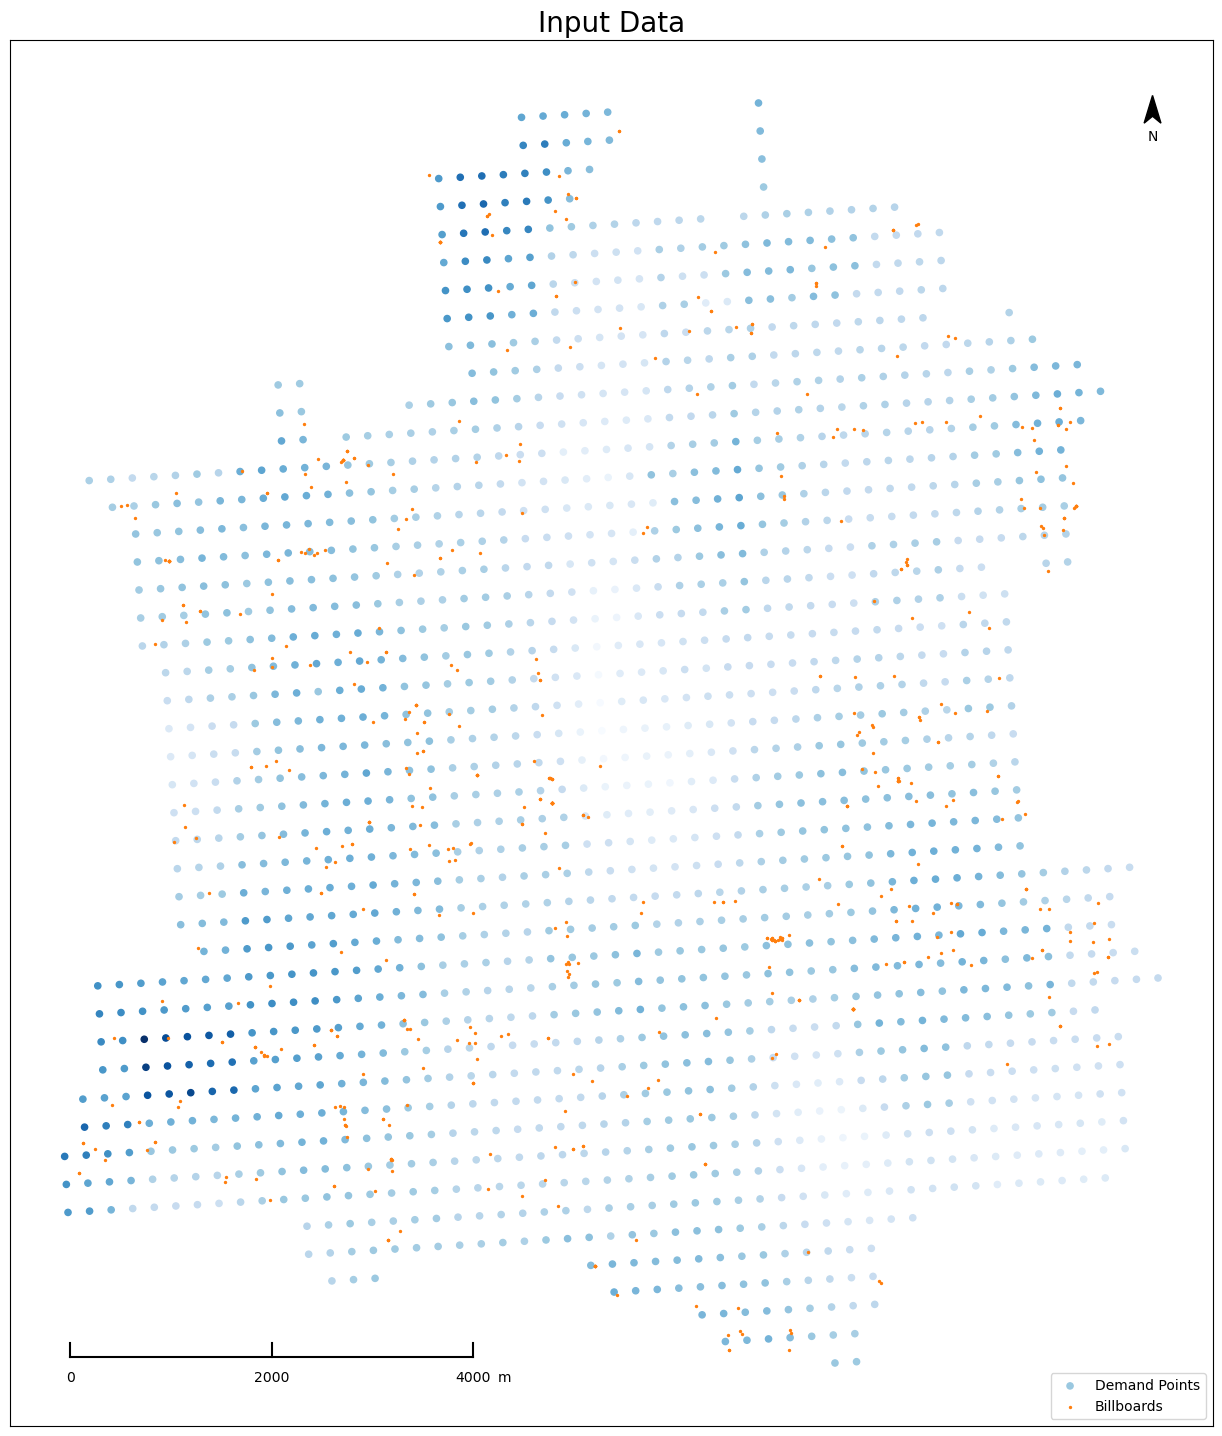

In [13]:
%%time
fig, ax = plt.subplots(figsize=(20,18))
# ax.scatter(ls['NORM_X'],ls['NORM_Y'],color='Blue', s=ls['speed_pct_freeflow_rev'] ,label = 'Demand Points')
ls.plot(ax = ax, column=ls['speed_pct_freeflow_rev'], k=5, markersize=20, cmap='Blues', label = 'Demand Points')
# ax.scatter(ls['NORM_X'], ls['NORM_Y'], c='C1', s=2, label = 'Demand points')
# ax.scatter(sitedf['POINT_X1'], sitedf['POINT_Y1'], c='C1', s=2, label = 'Billboards')
ax.scatter(sitedf['POINT_X'], sitedf['POINT_Y'], c='C1', s=2, label = 'Billboards')

ax.axis('scaled')
ax.tick_params(axis='both', left=False, top=False, right=False,
               bottom=False, labelleft=False, labeltop=False,
               labelright=False, labelbottom=False)

ax.set_title("Input Data", fontsize=20)
render_scale_bar(ax = ax, x=0.05, y=0.05)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
ax.legend(loc='lower right', markerscale = 1)

In [14]:
def generate_candidate_sites(sites, M=600, heuristic = None):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic:
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    if M is not None:
        if M > len(sites):
            M = None
    if heuristic is None or heuristic == '':
        if M is None:
            return sites
        index = np.random.choice(len(sites), M)
        return sites.iloc[index]
    elif heuristic == 'coverage':
        sites = sites.sort_values(by='pop_covered_2km', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'coverage_e':
        sites = sites.sort_values(by='pop_covered_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression':
        sites = sites.sort_values(by='weeklyImpr', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]
    elif heuristic == 'impression_e':
        sites = sites.sort_values(by='weeklyImpr_2km_exclusive', ascending=False).reset_index()
        if M is None:
            return sites
        return sites.iloc[:M]

In [15]:
np.random.seed()
bbs_ = generate_candidate_sites(sitedf, M=None, heuristic="")
users = np.array(ls[['NORM_X', 'NORM_Y']])
facilities = np.array(bbs_[['NORM_X', 'NORM_Y']])
# demand = np.array(ls['speed_pct_freeflow_rev_norm'])
demand = np.array(ls['speed_pct_freeflow_rev'])

p = 25
real_radius = 0.005
radius =500/S
# radius = real_radius/S
A = np.sum((facilities[:, np.newaxis, :] - users[np.newaxis, :, :]) ** 2, axis=-1) ** 0.5
mask1 = A <= radius
A[mask1] = 1
A[~mask1] = 0

In [16]:
radius

0.040011521781832746

In [17]:
users

array([[0.61135078, 0.        ],
       [0.62847735, 0.00103843],
       [0.52437416, 0.01703725],
       ...,
       [0.41387546, 0.99170427],
       [0.43097364, 0.99273954],
       [0.55066123, 1.        ]])

In [18]:
facilities

array([[0.62551748, 0.2808192 ],
       [0.54480588, 0.81775806],
       [0.81700196, 0.3093549 ],
       ...,
       [0.50067392, 0.04525876],
       [0.59954527, 0.54503655],
       [0.16431541, 0.55916317]])

In [19]:
demand

array([0.38763447, 0.38267426, 0.42527368, ..., 0.43514354, 0.4227391 ,
       0.43517596])

In [20]:
%%time
x_result, y_result, obj = gurobi_solver_MCLP(users, facilities, demand, p, A)
print(f"The avg objective of MCLP samples is: {obj}")
solutions = []
for i in range(len(bbs_)):
    if x_result[i] == 1.0:
        solutions.append(i)
solutions

The avg objective of MCLP samples is: 157.28062312058495
CPU times: total: 35.1 s
Wall time: 53 s


[17,
 62,
 66,
 76,
 88,
 90,
 98,
 107,
 232,
 238,
 253,
 260,
 276,
 277,
 278,
 300,
 311,
 313,
 314,
 320,
 324,
 340,
 342,
 434,
 448]

In [21]:
def plot_result(ls,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20,15))
    ls.plot(ax = ax, column=ls['权重'], k=5, markersize=1, cmap='Blues', label = 'LandScan')
    legend_plot_flag = {'current':False,'selected':False}

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:#ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=1, label = 'Current Billboards')

                circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
#             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], 500, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=1, label = 'Optimized Selected Billboards')

                circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
#             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], 0.005, color='red', fill=False, lw=2)

            ax.add_artist(circle)

    ax.axis('scaled')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m'
    ax.set_title(title, fontsize=20)
    render_scale_bar(ax = ax, x=0.05, y=0.05)
    render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
    ax.legend(loc='lower right', markerscale = 10)
    return ax

In [22]:
def plot_result(ls, opt_sites, radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20, 12))
    ls.plot(ax=ax, column=ls['权重'], k=5, markersize=5, cmap='Blues', label='Demand Points')
    legend_plot_flag = {'current': False, 'selected': False}

    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:  #ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=10, label='Current Billboards')
#                 circlelabel = 'Service Range for Current Billboards'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='red', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='red', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], 500, color='red', fill=False, lw=2)

            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=10,
                           label='Optimized Selected Billboards')
#                 circlelabel = 'Service Range for Optimized Selected Billboards'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='C1', marker='+', s=100)
            #             circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='C1', fill=False, lw=2, label = circlelabel)
            circle = plt.Circle(site[['POINT_X', 'POINT_Y']], 500, color='C1', fill=False, lw=2)
            ax.add_artist(circle)

    ax.axis('scaled')
    ax.tick_params(axis='both', left=False, top=False, right=False,
                   bottom=False, labelleft=False, labeltop=False,
                   labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve 500 m'
    ax.set_title(title, fontsize=20)
    render_scale_bar(ax=ax, x=0.05, y=0.05)
    render_north_arrow(ax=ax, x=0.95, y=0.95, size=0.01, ratio=0.7)
    ax.legend(loc='lower right', markerscale=2)
    return ax

In [23]:
ls

,Id,ORIG_FID,POINT_X,POINT_Y,ID_1,公交站,充电桩,公交线,路网密,建筑密,微博密,五环人,权重,X1,Y1,geometry,speed_pct_freeflow_rev,NORM_X,NORM_Y
0,0,5560,962307.237993,4.426070e+06,3345,0.558738,0.319934,0.613977,0.689915,0.222982,0.135555,0.162794,0.387634,0.697211,0.000000,POINT (962307.238 4426069.745),0.387634,0.611351,0.000000
1,0,5561,962521.258464,4.426083e+06,3346,0.553029,0.292546,0.596920,0.726470,0.190748,0.101671,0.189604,0.382674,0.717131,0.000000,POINT (962521.258 4426082.721),0.382674,0.628477,0.001038
2,0,5692,961220.343221,4.426283e+06,3472,0.645604,0.472511,0.730367,0.775091,0.165895,0.126567,0.084088,0.425274,0.597610,0.019920,POINT (961220.343 4426282.649),0.425274,0.524374,0.017037
3,0,5693,961434.355065,4.426296e+06,3473,0.686005,0.452299,0.706171,0.747698,0.197196,0.139586,0.079579,0.423076,0.617530,0.019920,POINT (961434.355 4426295.596),0.423076,0.541500,0.018073
4,0,5694,961648.367065,4.426309e+06,3474,0.686191,0.426197,0.678657,0.715106,0.244916,0.155636,0.161579,0.435432,0.637450,0.019920,POINT (961648.367 4426308.548),0.435432,0.558626,0.019110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,0,11715,959412.176280,4.438437e+06,9261,0.588136,0.430761,0.860124,0.854625,0.139914,0.092126,0.131634,0.455475,0.498008,0.896414,POINT (959412.176 4438436.622),0.455475,0.379679,0.989635
1555,0,11716,959625.841672,4.438450e+06,9262,0.585594,0.440043,0.806276,0.889464,0.159280,0.120853,0.108618,0.448545,0.517928,0.896414,POINT (959625.842 4438449.547),0.448545,0.396777,0.990669
1556,0,11717,959839.507215,4.438462e+06,9263,0.579874,0.437887,0.721991,0.876127,0.157460,0.162240,0.123550,0.435144,0.537849,0.896414,POINT (959839.507 4438462.478),0.435144,0.413875,0.991704
1557,0,11718,960053.172910,4.438475e+06,9264,0.583315,0.426467,0.673197,0.879327,0.145174,0.172749,0.119710,0.422739,0.557769,0.896414,POINT (960053.173 4438475.416),0.422739,0.430974,0.992740


<Axes: title={'center': 'Selected 25 Sites that Serve 500 m'}>

D:\Program Files\anaconda3\envs\higis\lib\site-packages\matplotlib\patches.py:1566: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
D:\Program Files\anaconda3\envs\higis\lib\site-packages\matplotlib\patches.py:1567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))


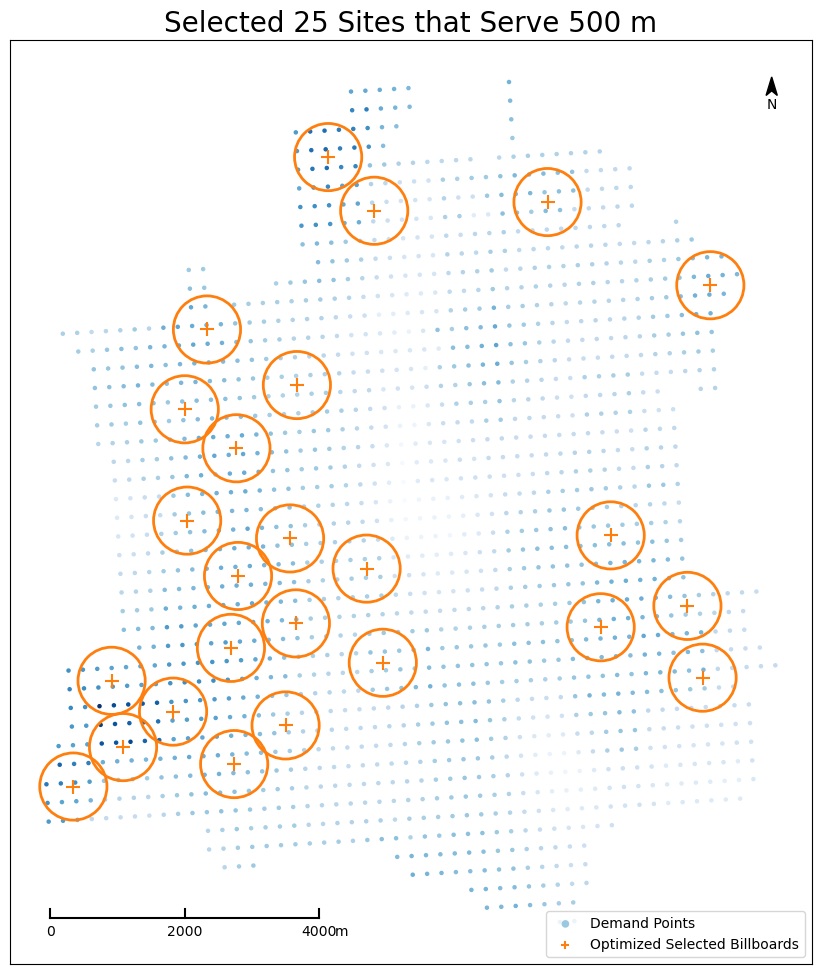

In [24]:

opt_sites = bbs_.iloc[solutions]
plot_result(ls,opt_sites,500)